# Exploring the neuron arbors in Larval zebrafish brain atlas

This notebook demonstrates how we use GeNePy3D to explore information of neuronal traces from the dataset of Larval brain atlas published by [Kunst *el al.*](https://www.sciencedirect.com/science/article/pii/S0896627319303915?via%3Dihub). The dataset consists of about 2000 neuronal traces along with 36 annotated brain regions.

## Load image volume contains the labels of brain regions

The image volume is the atlas depicting different zebrafish brain regions. Each region is annotated by a unique label ID. We used *nrrd* package to open the file.

In [1]:
import nrrd
import numpy as np

# Read brain atlas
regions, _ = nrrd.read('data/MPIN-Atlas.nrrd')
regions = np.swapaxes(regions,0,2) # swap axes to the ZYX order
print('shape (Z, Y, X):',regions.shape)

# Max label ID. The IDs of brain regions are from 1, 2, ..., lbl_max
lbl_max = np.max(regions)
print("nb. of brain regions:",lbl_max)

shape (Z, Y, X): (359, 974, 597)
nb. of brain regions: 36


## Compute the boundary surfaces of brain regions

The boundary surface of a brain region is computed via *from_volume()* in the class *Surface*. The resolution of surface is specified via the parameter *step_size* (higher value yields corser surface).

In [2]:
from genepy3d.obj import surfaces
from tqdm.notebook import trange, tqdm

# Surface resolution, larger step size gives coarser surface.
# It will take about 2-3 minutes for computing all regions with this step_size.
step_size = 15 

surfs = {}
for lbl in trange(1,lbl_max+1):
    surf = surfaces.Surface.from_volume(regions,lbl=lbl,step_size=step_size)
    surfs[lbl] = surf

  0%|          | 0/36 [00:00<?, ?it/s]

Plot all surfaces together.

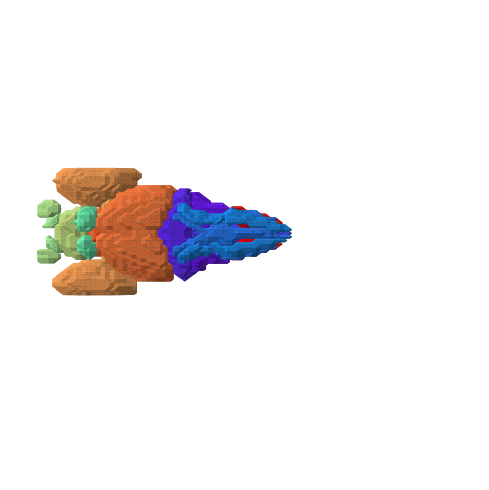

In [3]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Color map
mycmp = colormaps.get_cmap('rainbow')

# Camera view
azim = 0
elev = 90 # set 0 for AP-DV, and 90 for AP-ML
dist = 60

# Box aspect
aspect = (3,4,3) # aspect ratio in x, y and z
zoom = 0.15

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

for lbl in range(1,lbl_max+1):
    surfs[lbl].plot(ax,args_3d={'color':mycmp(lbl/lbl_max)})

ax.view_init(azim=azim,elev=elev);
ax.set_box_aspect(aspect,zoom=zoom);
ax.axis('off');
plt.tight_layout();

## Load neuronal traces

The dataset consists of about two thousands neuronal traces in *swc* format. For demonstration, we only take some traces from the group of *retinal ganglion neurons* and explore their morphologies over the brain regions they intersect. 

In [4]:
from genepy3d.io import swc

# Create SWC instance for manipulating the swc file
filepath = "data/retinal_ganglion_cells/"
f = swc.SWC(filepath,recursive=True)

# List of neuron ID
neuids = f.get_neuron_id().values
print("nb. of imported neurons:",len(neuids))

# Load neurons
neurons = f.get_neurons()

nb. of imported neurons: 10


Let's plot all together.

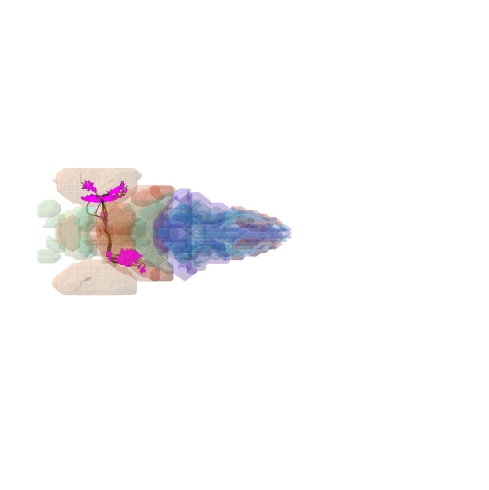

In [5]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

for neuid in neuids:
    neurons[neuid].plot(ax,show_root=False,show_leaves=False,branchingnodes_args={'s':1},line_args={'lw':0.5})

for lbl in range(1,lbl_max+1):
    surfs[lbl].plot(ax,args_3d={'color':mycmp(lbl/lbl_max),'alpha':0.15})

ax.view_init(azim=azim,elev=elev);
ax.set_box_aspect(aspect,zoom=zoom);
ax.axis('off');
plt.tight_layout();

## Find the host brain regions

To find which regions the neurons are in, one way is to check wheather the traced points are inside the regions. We first convert neuronal traces into point cloud.

In [6]:
pnt_cloud = neurons[neuids[0]].to_points() # convert first traces to point cloud
for neuid in neuids[1:]:
    pnt_cloud.append(neurons[neuid].to_points())

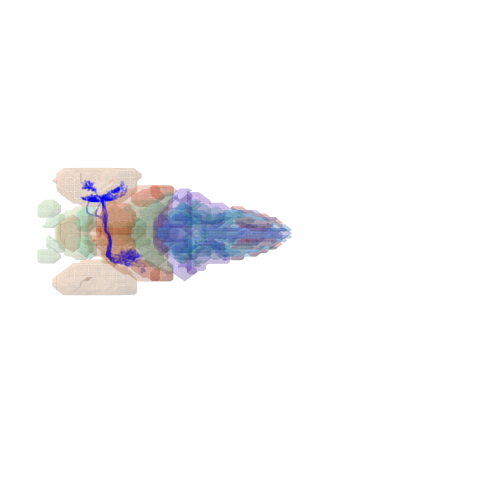

In [7]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

pnt_cloud.plot(ax,point_args={'s':0.1,'alpha':0.1})

for lbl in range(1,lbl_max+1):
    surfs[lbl].plot(ax,args_3d={'color':mycmp(lbl/lbl_max),'alpha':0.15})

ax.view_init(azim=azim,elev=elev);
ax.set_box_aspect(aspect,zoom=zoom);
ax.axis('off');
plt.tight_layout();

Next, use *pointsurface.inonout()* function in *genepy3d_gpl.interact* to check the in/out condition. One remark is that some regions can have two distinct surfaces due to the brain symmetry. We must split them before using the function.

In [8]:
from genepy3d_gpl.interact import pointsurface

lbl_in = []
pnt_cloud_in = {}

for lbl in trange(1,lbl_max+1):
    surf = surfs[lbl]
    for surf_sub in surf.split():
        item, _, _ = pointsurface.inonout(pnt_cloud,surf_sub)
        if item is not None:
            lbl_in.append(lbl)
            pnt_cloud_in[lbl] = item

print("regions that the neurons are inside:",lbl_in)

  0%|          | 0/36 [00:00<?, ?it/s]

regions that the neurons are inside: [26, 27, 28, 30, 31]


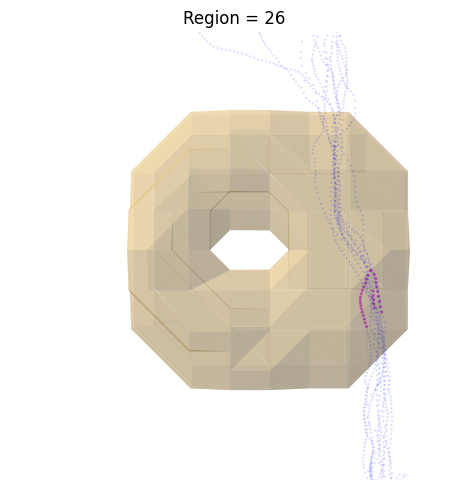

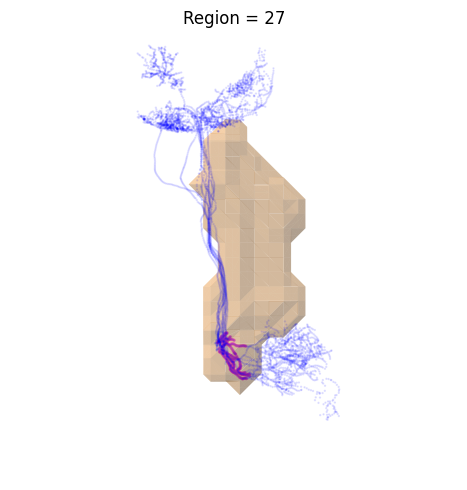

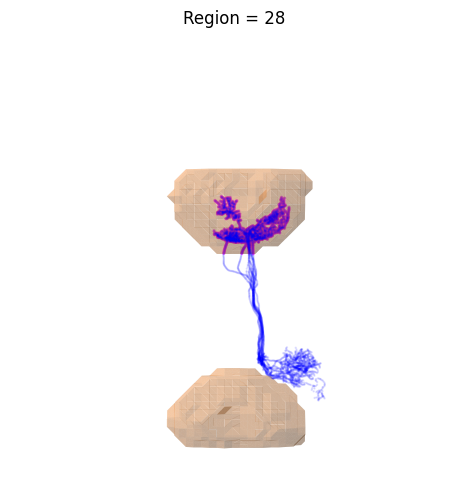

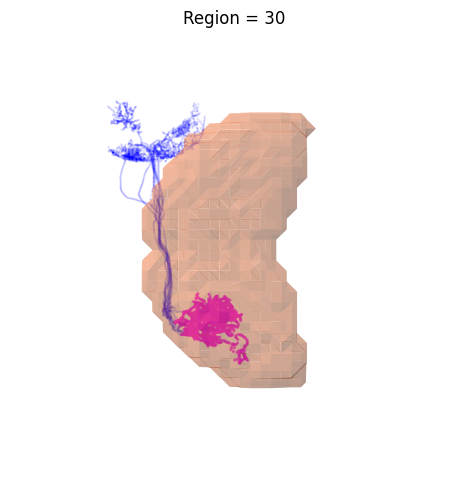

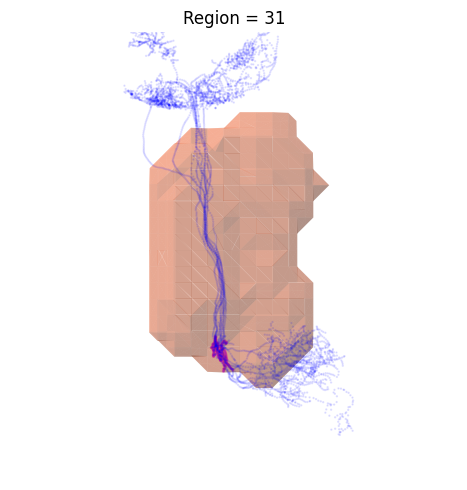

In [9]:
for lbl in lbl_in:

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111,projection="3d")
    pnt_cloud.plot(ax,point_args={'s':0.5,'alpha':0.1})
    pnt_cloud_in[lbl].plot(ax,point_args={'s':2.,'alpha':0.5,'color':'magenta'})
    surfs[lbl].plot(ax,args_3d={'color':mycmp(lbl/lbl_max),'alpha':0.3})
    
    ax.set_title("Region = {}".format(lbl));
    ax.view_init(azim=azim,elev=elev);
    ax.axis('off');
    plt.tight_layout();

## Number of branchings

One simple measurement is the number of branchings within each region. We iterate every neuronal trace, extract its branched positions and count the branchings within a given region.

In [10]:
import pandas as pd

records = []
for lbl in lbl_in:
    surf = surfs[lbl]
    for neuid in neuids:
        neu = neurons[neuid]
        branchings = neu.to_points(neu.get_branchingnodes()) # get branched points
        nb_branchings = 0 # init number of branchings
        for surf_sub in surf.split():
            item, _, _ = pointsurface.inonout(branchings,surf_sub) # get branchings inside of the region
            if item is not None:
                nb_branchings += item.size
        records.append([lbl,neuid,nb_branchings])

# build branching table
df_branching = pd.DataFrame(records,columns=['RegID','NeuID','NbBranchings'])
df_branching.head(10)

RegID  NeuID  NbBranchings
0     26      0             0
1     26      1             0
2     26      2             0
3     26      3             0
4     26      4             0
5     26      5             0
6     26      6             0
7     26      7             0
8     26      8             0
9     26      9             0

Let's plot the result.

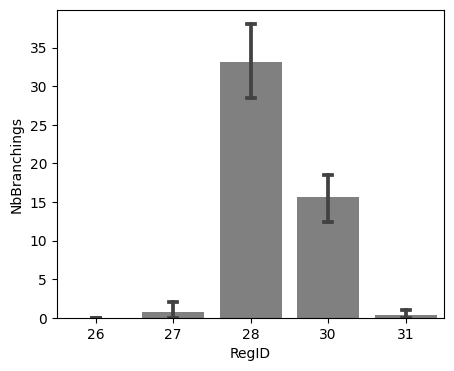

In [11]:
import seaborn as sns

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
sns.barplot(x='RegID',y='NbBranchings',data=df_branching,capsize=0.1,color='gray');

We can colored map the result on the brain surfaces. We first compute the averaged branchings per region:

In [12]:
df_nbbranchings = df_branching.groupby('RegID').mean()['NbBranchings']
df_nbbranchings

RegID
26     0.0
27     0.8
28    33.1
30    15.6
31     0.4
Name: NbBranchings, dtype: float64

Then, colored map the values:

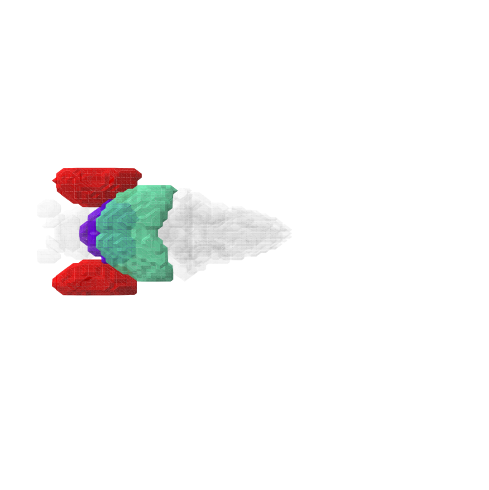

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

for lbl in range(1,lbl_max+1):
    if lbl in lbl_in:
        clc_value = df_nbbranchings.loc[lbl] / df_nbbranchings.max()
        surfs[lbl].plot(ax,args_3d={'color':mycmp(clc_value),'alpha':0.7})
    else:
        surfs[lbl].plot(ax,args_3d={'color':'white','alpha':0.05})
    
ax.view_init(azim=azim,elev=elev);
ax.set_box_aspect(aspect,zoom=zoom);
ax.axis('off');
plt.tight_layout();

## Tortuosity (or wiggliness)

Another aspect is to study how straight or tourtous the neuronal trace is across brain regions. For simplyfing, we extract the longest branch originating from the root (cell body) toward the leaf and measure the tortuosity (wiggliness as another name) w.r.t. the regions it is within. The longest branch is called "spine" can is extracted by:

In [14]:
spines = {}
for neuid in neuids:
    neu = neurons[neuid]
    spines[neuid] = neu.to_curve(neu.compute_spine())

Let's plot them.

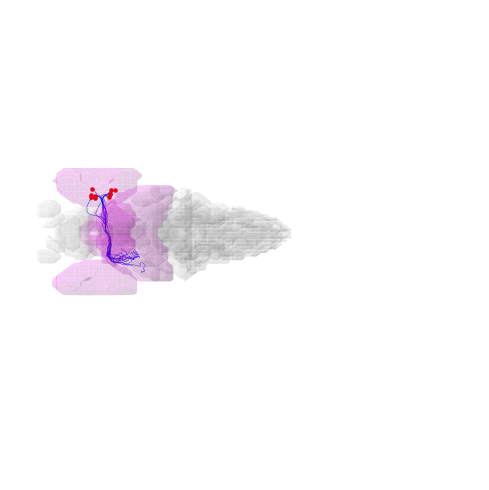

In [15]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

for spine in spines.values():
    spine.plot(ax,line_args={"linewidth":0.3,"color":"blue"},root_args={"s":5,"color":"red"})

for lbl in range(1,lbl_max+1):
    if lbl in lbl_in:
        surfs[lbl].plot(ax,args_3d={'color':'magenta','alpha':0.1})
    else:
        surfs[lbl].plot(ax,args_3d={'color':'white','alpha':0.1})
    
ax.view_init(azim=azim,elev=elev);
ax.set_box_aspect(aspect,zoom=zoom);
ax.axis('off');
plt.tight_layout();

We now iterate each spine, extract portions that are inside a brain region and compute the tortuosity. Use the *curvesurface.inonout()* in *genepy3d_gpl.interact* to check in/out between a curve (spine) and a surface.

In [16]:
from genepy3d_gpl.interact import curvesurface

records = []
for lbl in lbl_in:
    surf = surfs[lbl]
    for neuid in neuids:
        spine = spines[neuid]
        tortuosity = []
        for surf_sub in surf.split():
            items, _, _ = curvesurface.inonout(spine,surf_sub)
            if items is not None:
                for crv in items:
                    tortuosity.append(crv.compute_tortuosity())
        if len(tortuosity)>0:
            tortuosity_mean = np.mean(tortuosity)
        else:
            tortuosity_mean = -1     
        records.append([lbl,neuid,tortuosity_mean])

# Build table of tortuosity
df_tortuo = pd.DataFrame(records,columns=['RegID','NeuID','Tortuosity'])
df_tortuo.head(10)

RegID  NeuID  Tortuosity
0     26      0   -1.000000
1     26      1   -1.000000
2     26      2   -1.000000
3     26      3   -1.000000
4     26      4   -1.000000
5     26      5    1.171707
6     26      6    1.001325
7     26      7    1.005846
8     26      8    1.025453
9     26      9    1.052281

There are cases the spine does not intersect the brain region and results in tortuosity equal *-1*. Thus we exclude those cases from the table.

In [17]:
df_tortuo = df_tortuo[df_tortuo['Tortuosity']>-1]
df_tortuo.head(10)

RegID  NeuID  Tortuosity
5      26      5    1.171707
6      26      6    1.001325
7      26      7    1.005846
8      26      8    1.025453
9      26      9    1.052281
10     27      0    1.069521
11     27      1    1.038648
12     27      2    1.029862
13     27      3    1.032422
14     27      4    1.312710

Now, let's plot the result:

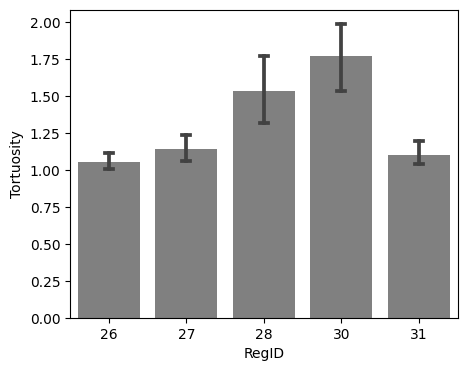

In [18]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
sns.barplot(x='RegID',y='Tortuosity',data=df_tortuo,capsize=0.1,color='gray');

And color map the mean tortuosity on the surfaces.

In [19]:
df_tortuo_mean = df_tortuo.groupby('RegID').mean()['Tortuosity']
df_tortuo_mean

RegID
26    1.051323
27    1.138385
28    1.535018
30    1.770655
31    1.096738
Name: Tortuosity, dtype: float64

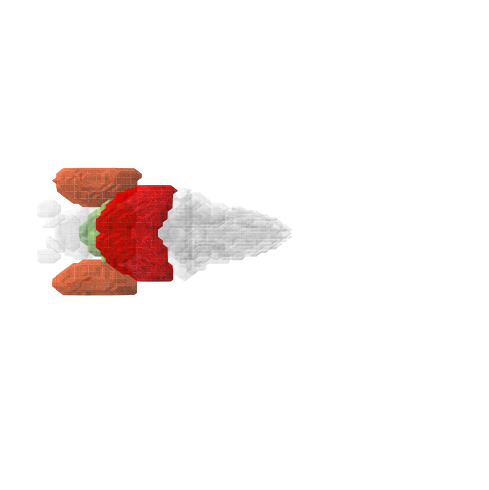

In [20]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

for lbl in range(1,lbl_max+1):
    if lbl in lbl_in:
        clc_value = df_tortuo_mean.loc[lbl] / df_tortuo_mean.max()
        surfs[lbl].plot(ax,args_3d={'color':mycmp(clc_value),'alpha':0.7})
    else:
        surfs[lbl].plot(ax,args_3d={'color':'white','alpha':0.1})
    
ax.view_init(azim=azim,elev=elev);
ax.set_box_aspect(aspect,zoom=zoom);
ax.axis('off');
plt.tight_layout();

## Curvatures

To access the local morphology of the neuronal trace, we can look at its curvatures. The measurement of curvatures is often noisy and should be smoothed out by e.g. gaussian filter.

In [21]:
from scipy.ndimage import gaussian_filter1d
kappas = {}
for neuid in neuids:
    spine = spines[neuid]
    kappa = spine.convolve_gaussian(sigma=2.).compute_curvature() # smooth the curve before computing the curvature
    kappa = gaussian_filter1d(kappa,sigma=2.) # smooth the curvature values
    kappas[neuid] = kappa

Let's plot the curvatures. Here we set the upper value of the color map by 95th percentile of the curvatures for clearer observation.

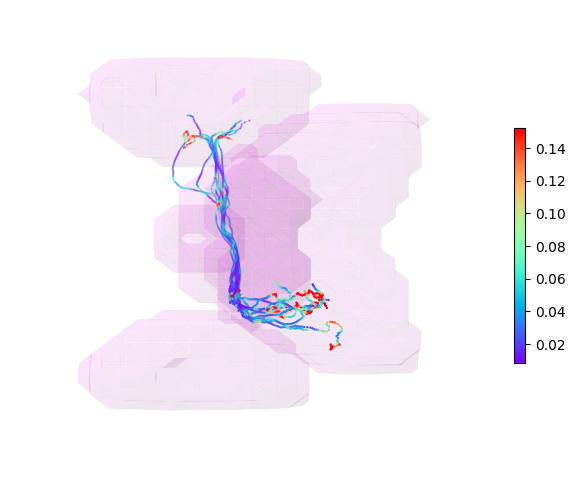

In [22]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

kappas_all = np.concatenate([item for item in kappas.values()])
upper_limit = np.percentile(kappas_all,95)

for neuid in neuids:
    spine = spines[neuid]
    kappa = kappas[neuid]
    _, point_pl, _ = spine.plot(ax,line_args={"linewidth":0.1,"color":"k"},point_args={"c":kappa,"cmap":mycmp,"s":0.5,"vmax":upper_limit},show_root=False)

for lbl in range(1,lbl_max+1):
    if lbl in lbl_in:
        surfs[lbl].plot(ax,args_3d={'color':'magenta','alpha':0.05})
    
fig.colorbar(point_pl,shrink=0.5)

ax.view_init(azim=azim,elev=elev);
ax.set_box_aspect(aspect,zoom=0.7);
ax.axis('off');
plt.tight_layout();

For better observation of the curvatures, an animation in 3D can be found [**here**](https://drive.google.com/file/d/1E8kHShA0syBi85qMexTeaNg4mlhWeQLI/view?usp=sharing).

## Main turns

We can even go further to identify the positions on the spine showing the relevant changes of orientation via the *main_turns()* function. The function looks for the changes of curvatures across different scales of the spine curve (computed by convolving with Gaussian across various stdev). Note that, the curve should be smoothed and resampled equally before calling the *main_turns()* function.

In [23]:
turns = {}
for neuid in neuids:
    spine = spines[neuid]
    spine2 = spine.convolve_gaussian(sigma=2.).resample(unit_length=2) # smooth and resample with sampling length = 2 microns
    turns_ids = spine2.main_turns() # return indices corresponding to identifed main turns
    coors = spine2.coors[turns_ids] # get the main turns coordinates
    turns[neuid] = coors

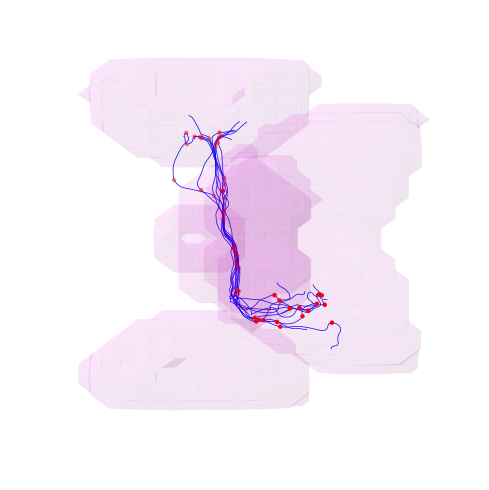

In [24]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

for neuid in neuids:
    spine = spines[neuid]
    coors = turns[neuid]
    spine2 = spine.convolve_gaussian(sigma=2.).resample(unit_length=4)
    spine2.plot(ax,line_args={"linewidth":0.5,"color":"blue"},show_root=False)
    ax.scatter(coors[:,0],coors[:,1],coors[:,2],color='red',s=5)

for lbl in range(1,lbl_max+1):
    if lbl in lbl_in:
        surfs[lbl].plot(ax,args_3d={'color':'magenta','alpha':0.05})
    
ax.view_init(azim=azim,elev=elev);
ax.set_box_aspect(aspect,zoom=0.7);
ax.axis('off');
plt.tight_layout();

For better observation of the main turns, an animation in 3D can be found [**here**](https://drive.google.com/file/d/1yzSOfRlqPOY4_Rg2ODnknQ9rWydbsu5n/view?usp=sharing).